In [1]:
import sys
import os
home = os.path.expanduser("~")
sys.path.append(f'{home}/TorchFiber')

# 1.EDC, PBC, DBP

Text(0.5, 1.0, 'Nch=1.0, Rs=40.0G,  discard=10000 symbols')

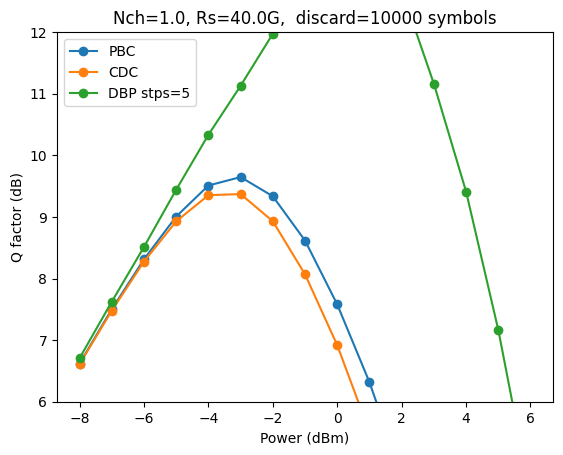

In [4]:
import pickle, matplotlib.pyplot as plt, numpy as np, os
from src.TorchDSP.dataloader import get_Qsq, getQsq_fromdir, mean_peak


discard = 10000
i,j = 1,0

Q2,Rs,Nch,P = get_Qsq('../outputs/Qfactor/Q2000/MTLoss/pbc.pkl', discard=discard)
pbc = Q2['pbc'][i, j]

Q1,Rs,Nch,P = get_Qsq('../outputs/Qfactor/Q2000/baselines.pkl', discard=discard)
cdc = Q1['CDC'][i, j,:]

Q, Rs, Nch, P = getQsq_fromdir('../outputs/Qfactor/Q2000/hpbc_MTLoss/', discard=discard)

plt.figure(dpi=100)
plt.plot(P, pbc,'-o', label='PBC')
plt.plot(P, cdc,'-o', label='CDC')
plt.plot(P, Q1['DBP stps=5'][i,j], '-o', label='DBP stps=5')
for key in Q.keys():
    if key in ['hpbc_2', 'hpbc_3', 'hpbc_4']:
        plt.plot(P, Q[key][i, j ,:], '-o', label=key)


plt.xlabel('Power (dBm)')
plt.ylabel('Q factor (dB)')
plt.ylim(6, 12)
plt.legend()
plt.title(f'Nch={Nch[j]}, Rs={Rs[i]}G,  discard={discard} symbols')

# NNeq

Text(0.5, 1.0, 'Q factor - Power (Nch=1, Rs=40G)')

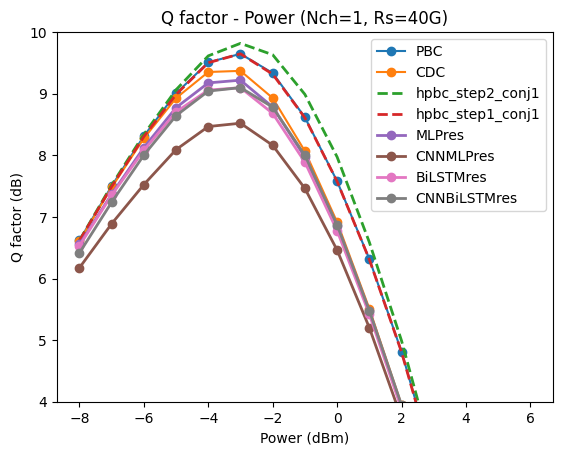

In [5]:
import pickle

epoch = 4
method = ['MLPres', 'CNNMLPres',  'BiLSTMres', 'CNNBiLSTMres']

plt.plot(P, pbc,'-o', label='PBC')
plt.plot(P, cdc,'-o', label='CDC')


for key in Q.keys():
    plt.plot(P, Q[key][i, j,:], '--', linewidth=2, label=key)


for m in method:
    a,b = pickle.load(open(f'../outputs/Qfactor/Q2000/nneq_MTLoss/{m}_{epoch}.pth', 'rb'))
    plt.plot(P, a[f'BER from {discard}th symb'][f'models/nneq_MTLoss/{m}_{epoch}.pth']['Qsq'], '-o', linewidth=2, label=m)

plt.xlabel('Power (dBm)')
plt.ylabel('Q factor (dB)')
plt.ylim(4, 10)
plt.legend()
plt.title('Q factor - Power (Nch=1, Rs=40G)')

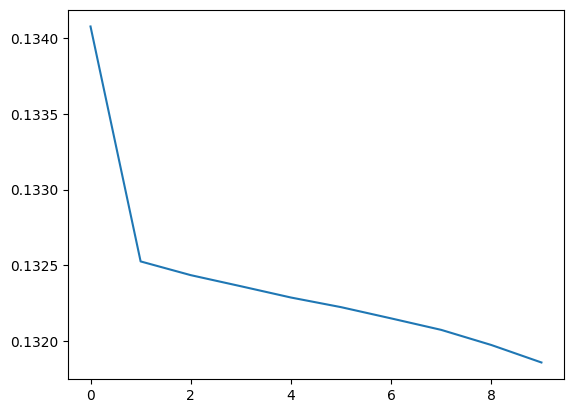

In [6]:
import torch, matplotlib.pyplot as plt
dic = torch.load('../models/NNeq/nneq_MeanLoss_init0/MLPres_10.pth', map_location='cpu')
plt.plot(dic['loss'])

Text(0.5, 1.0, 'Q factor - Power (Nch=1, Rs=40G)')

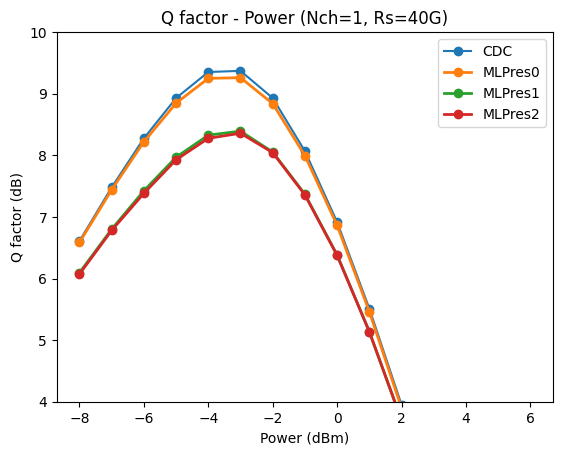

In [8]:
import pickle

epoch = 4
method = ['MLPres']
discard = 1000

plt.plot(P, cdc,'-o', label='CDC')

for m in method:
    for epoch in [0, 1, 2]:
        a,b = pickle.load(open(f'../outputs/Qfactor/Q2000/nneq_MeanLoss_init0/{m}_{epoch}.pth', 'rb'))
        plt.plot(P, a[f'BER from {discard}th symb'][f'models/nneq_MeanLoss_init0/{m}_{epoch}.pth']['Qsq'], '-o', linewidth=2, label=m+str(epoch))

plt.xlabel('Power (dBm)')
plt.ylabel('Q factor (dB)')
plt.ylim(4, 10)
plt.legend()
plt.title('Q factor - Power (Nch=1, Rs=40G)')

# MetaDSP show loss

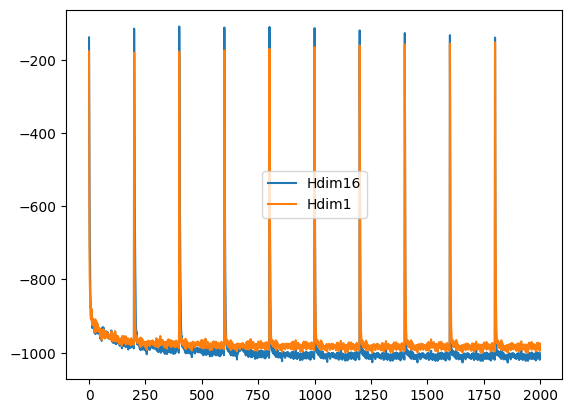

In [10]:
import torch, matplotlib.pyplot as plt
from src.TorchDSP.dsp import DSP 

dic = torch.load('../models/MetaDSP/MetaDBP_metagrutest_lossMT_stepmax5e-2_lr1e-4_batch360_iter200_tbpl200_Hdim16_Hdepth2/10.pth', map_location='cpu')
model = DSP(**dic['model info'])
model.load_state_dict(dic['model'])
plt.plot(dic['loss'], label='Hdim16')

dic = torch.load('../models/MetaDSP/MetaDBP_metagrutest_lossMT_stepmax5e-2_lr1e-4_batch360_iter200_tbpl200_Hdim1_Hdepth2/10.pth', map_location='cpu')
model = DSP(**dic['model info'])
model.load_state_dict(dic['model'])
plt.plot(dic['loss'], label='Hdim1')
plt.legend()

# High-order PBC

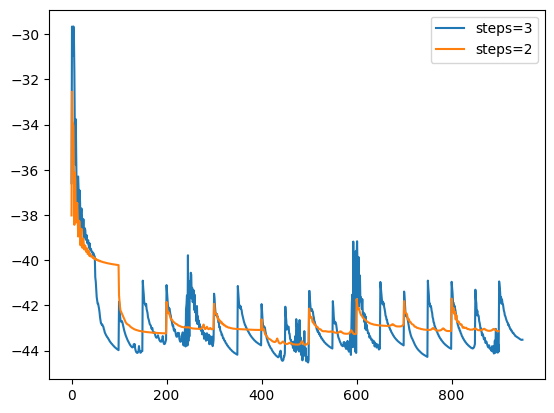

In [12]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from src.TorchDSP.nneq import HPBC_step, HPBC


dic = torch.load('../models/HPBC/L200_rho0.5_steps3_lossMT_batchs19_tbpl5000_iters50_lr1e-4_epoch1/Nch1_Rs160.pth', map_location='cpu')
net = HPBC(**dic['model info'])
net.load_state_dict(dic['model'])

plt.plot(dic['loss'], label='steps=3')

dic = torch.load('../models/HPBC/L200_rho0.5_steps2_lossMT_batchs9_tbpl10000_iters100_lr1e-4_epoch1/Nch1_Rs160.pth', map_location='cpu')
net = HPBC(**dic['model info'])
net.load_state_dict(dic['model'])

plt.plot(dic['loss'], label='steps=2')
plt.legend()

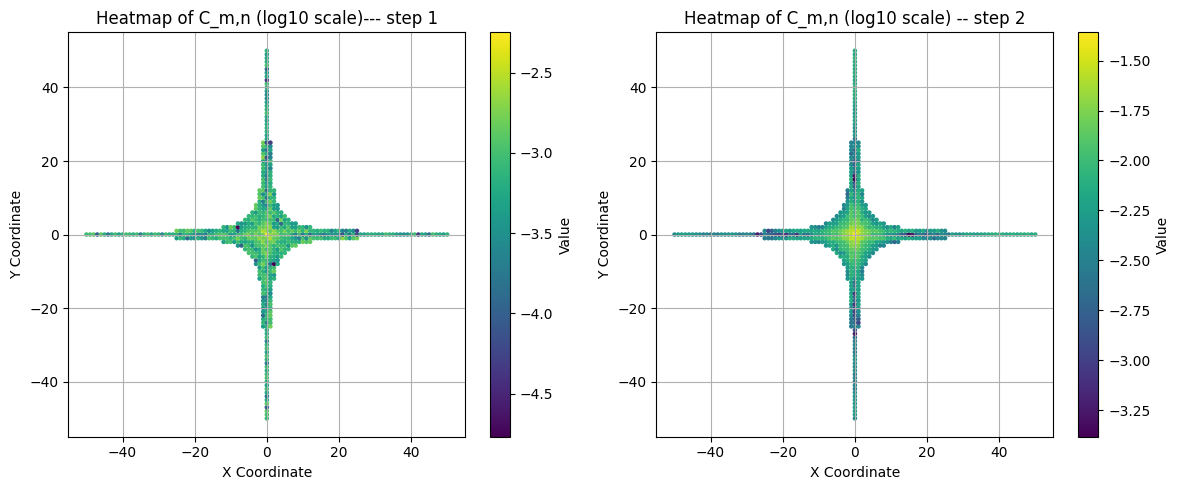

In [14]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from src.TorchDSP.nneq import HPBC

dic = torch.load('../models/HPBC/L100_rho0.5_steps2_lossMT_batchs9_tbpl10000_iters100_lr1e-4_epoch1/Nch1_Rs20.pth', map_location='cpu')
net = HPBC(**dic['model info'])
net.load_state_dict(dic['model'])

# 假设的坐标和值
model1 = net.HPBC_steps[0]
coords1 = model1.index
values1 = np.log10(np.abs(model1.get_C()))[0]   # type: ignore

model2 = net.HPBC_steps[1]
coords2 = model2.index
values2 = np.log10(np.abs(model2.get_C()))[0]   # type: ignore

# 从坐标中提取x和y
x1, y1 = zip(*coords1)
x2, y2 = zip(*coords2)

# 创建子图，一行两列
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 在第一个子图中创建散点图
sc1 = ax1.scatter(x1, y1, c=values1, cmap='viridis', s=5)  # `cmap`指定颜色映射，`s`指定点的大小
cbar1 = plt.colorbar(sc1, ax=ax1, label='Value')  # 添加颜色条到第一个子图
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.set_title('Heatmap of C_m,n (log10 scale)--- step 1')
ax1.grid(True)

# 在第二个子图中创建散点图
sc2 = ax2.scatter(x2, y2, c=values2, cmap='viridis', s=5)  # `cmap`指定颜色映射，`s`指定点的大小
cbar2 = plt.colorbar(sc2, ax=ax2, label='Value')  # 添加颜色条到第二个子图
ax2.set_xlabel('X Coordinate')
ax2.set_ylabel('Y Coordinate')
ax2.set_title('Heatmap of C_m,n (log10 scale) -- step 2')
ax2.grid(True)

# 调整子图的间距
plt.tight_layout()

# 显示图形
plt.show()


# HPBC vs MetaDSP

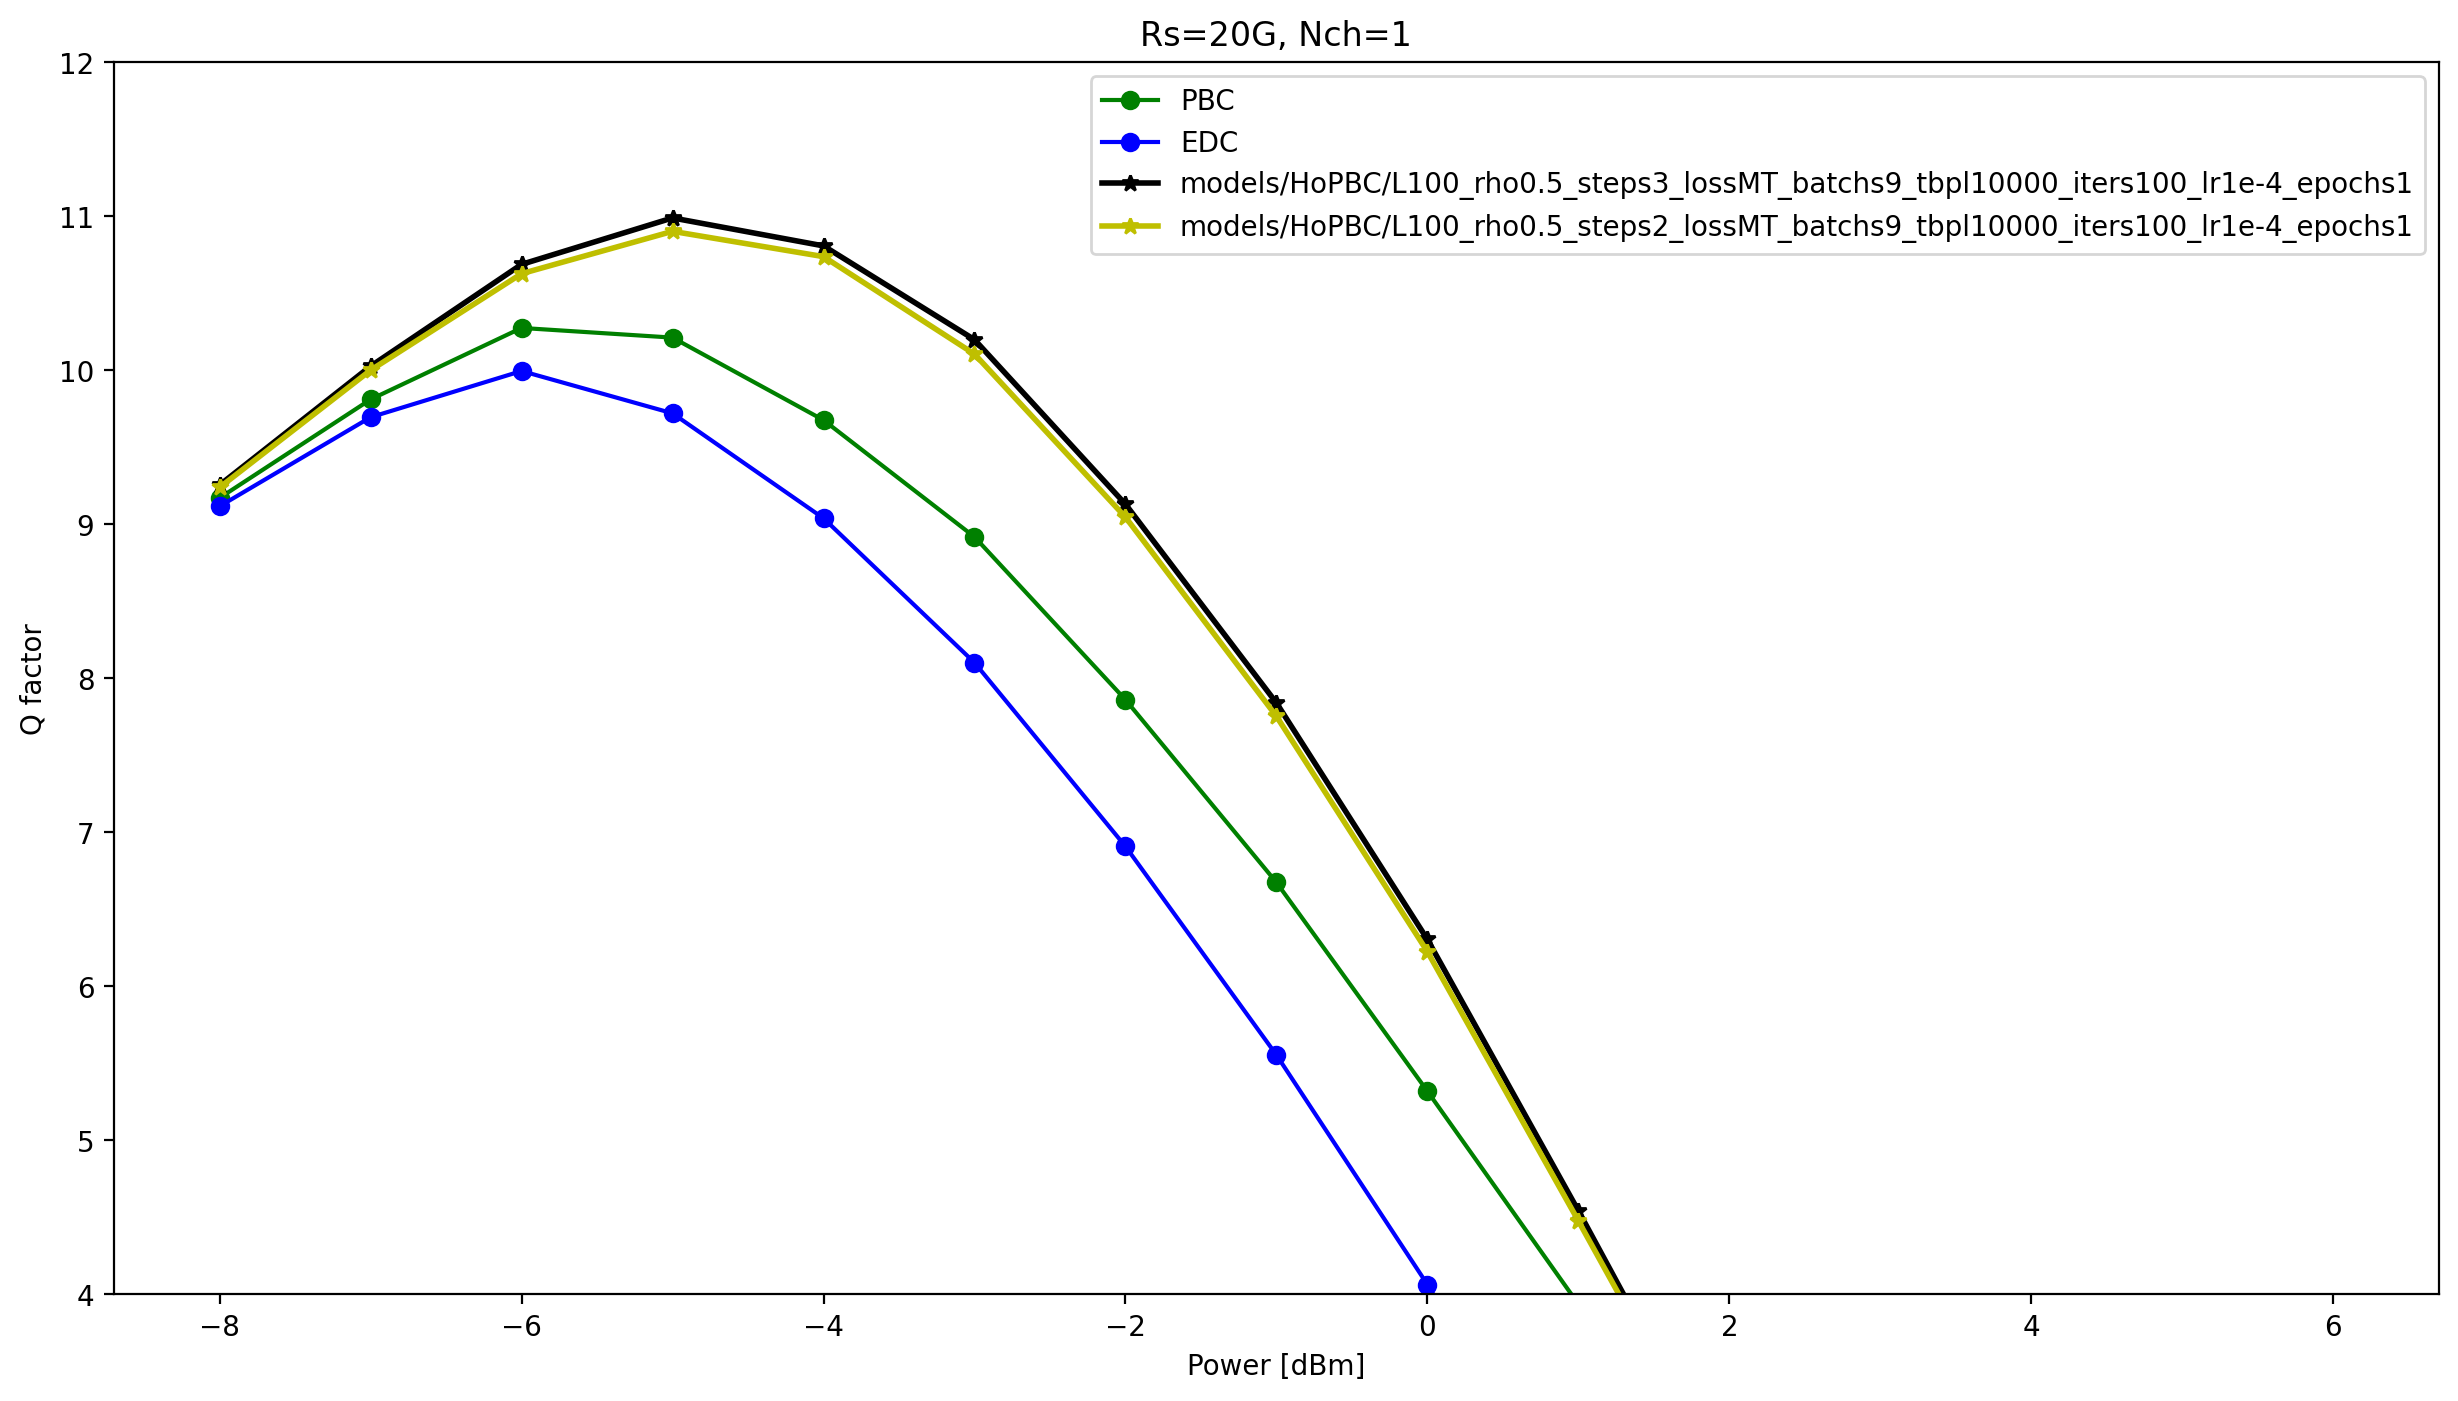

In [16]:
from src.TorchSimulation.receiver import  BER 
from src.TorchDSP.dataloader import get_k, get_k_batch
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['g',  'b', 'k', 'y', 'm', 'c'])  # type: ignore

discard = 10000
i,j = 0, 0

Q2,Rs,Nch,P = get_Qsq('../outputs/Qfactor/Q2000/MTLoss/pbc.pkl', discard=discard)
pbc = Q2['pbc'][i, j]

Q1,Rs,Nch,P = get_Qsq('../outputs/Qfactor/Q2000/baselines.pkl', discard=discard)
cdc = Q1['CDC'][i, j,:]

Q, Rs, Nch, P = getQsq_fromdir('../outputs/Qfactor_1205/Q2000/few/', discard=discard)


plt.figure(figsize=(15,8), dpi=200)
plt.plot(P, pbc, '-o', label='PBC')
plt.plot(P, cdc, '-o', label='EDC')

# for key in Q.keys():
#     if 'FoPBC/' in key and 'L200' in key:
#         plt.plot(P, Q[key][i,j,:], '-d', linewidth=2, label=key)

for key in Q.keys():
    if 'HoPBC' in key and 'L100' in key and 'tbpl10000' in key:
        plt.plot(P, Q[key][i,j,:], '-*', linewidth=2, label=key)

# for key in Q.keys():
#     if 'HoPBC' in key and 'L100' in key and 'tbpl5000' in key and 'iters400' in key:
#         plt.plot(P, Q[key][i,j,:], '-*', linewidth=2, label=key)

# for key in Q.keys():
#     if 'FoPBCNN/' in key and 'batchs19' in key:
#         plt.plot(P, Q[key][i,j,:], '--o', linewidth=2, label=key)


# for key in Q.keys():
#     if 'HPBC' in key and 'L100' in key and 'steps3' in key:
#         plt.plot(P, Q[key][i,j,:], '-*', linewidth=2, label=key)

# for key in Q.keys():
#     if 'HPBC' in key and 'L100' in key and 'steps2' in key:
#         plt.plot(P, Q[key][i,j,:], '-*', linewidth=2, label=key)

# for key in Q.keys():
#     if 'HPBC' in key and 'L200' in key and 'steps3' in key:
#         plt.plot(P, Q[key][i,j,:], '-*', linewidth=2, label=key)


# for key in Q.keys():
#     if 'SOPBC' in key:
#         plt.plot(P, Q[key][i,j,:], '-D', linewidth=2, label=key)

# for key in Q.keys():
#     if 'DBP' in key and '10.pth' in key:
#         plt.plot(P, Q[key][i,j,:], '--*', linewidth=2, label=key)

# for key in Q.keys():
#     if '10.pth' in key or 'HPBC' in key:
#         plt.plot(P, Q[key][i,j,:], '-*', linewidth=2, label=key)


plt.xlabel('Power [dBm]')
plt.ylabel('Q factor')
plt.title(f'Rs={int(Rs[i])}G, Nch={int(Nch[j])}')
plt.ylim(4,12)
plt.legend()

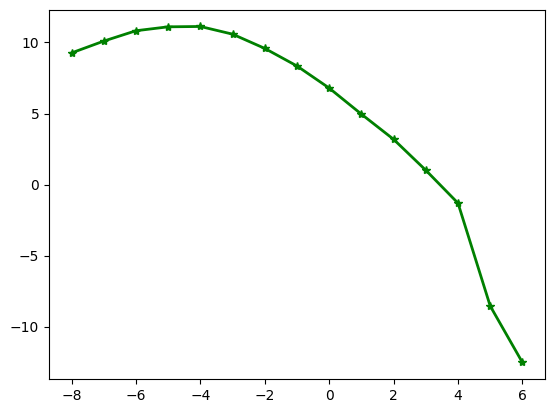

In [17]:
for key in Q.keys():
    if 'HPBC' in key and 'L200' in key and 'steps2' in key:
        plt.plot(P, Q[key][i,j,:], '-*', linewidth=2, label=key)

# HPBC迭代格式对比

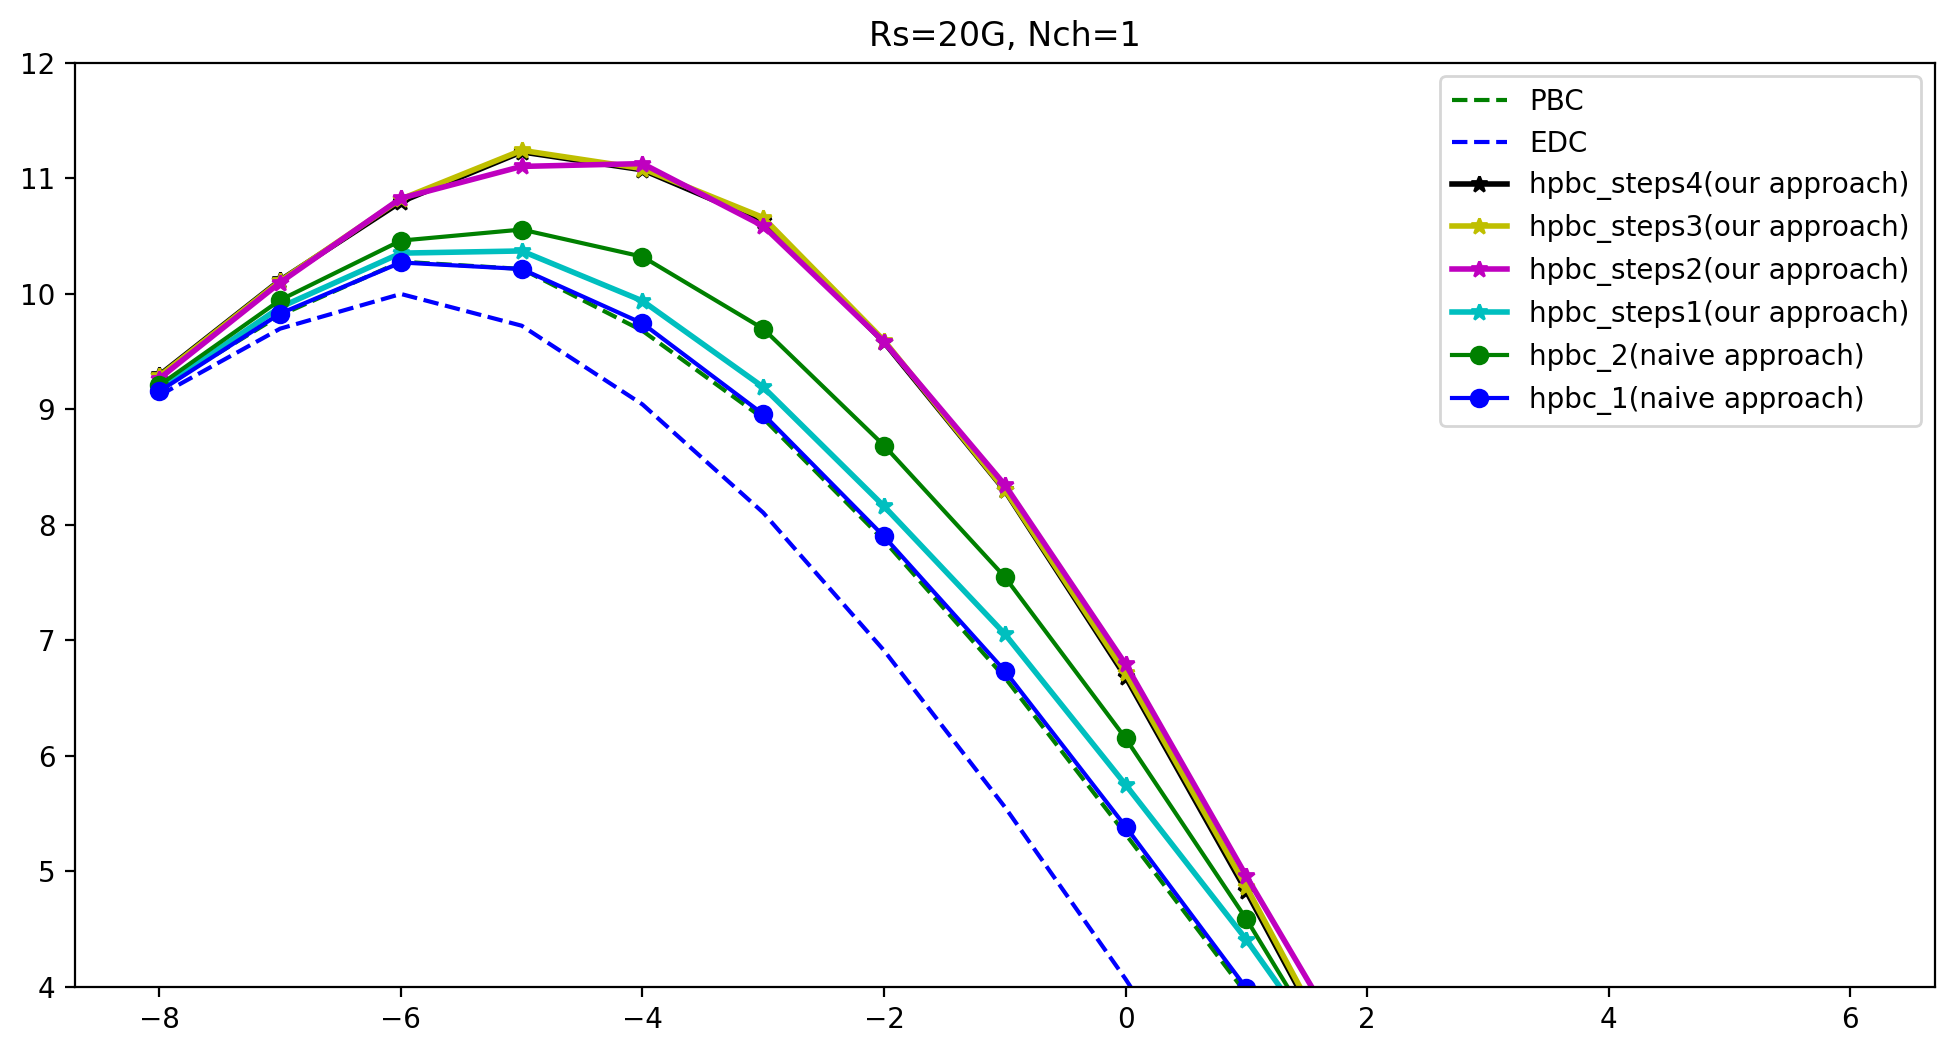

In [18]:
import pickle, matplotlib.pyplot as plt, numpy as np, os
from src.TorchSimulation.receiver import  BER 
from src.TorchDSP.dataloader import get_k, get_k_batch


discard = 10000
i,j = 0, 0

Q2,Rs,Nch,P = get_Qsq('../outputs/Qfactor/Q2000/MTLoss/pbc.pkl', discard=discard)
pbc = Q2['pbc'][i, j]
Q1,Rs,Nch,P = get_Qsq('../outputs/Qfactor/Q2000/baselines.pkl', discard=discard)
cdc = Q1['CDC'][i, j,:]


# CDC, PBC
plt.figure(figsize=(12,6), dpi=200)
plt.plot(P, pbc, '--', label='PBC')
plt.plot(P, cdc, '--', label='EDC')

# HPBC
Q, Rs, Nch, P = getQsq_fromdir('../outputs/Qfactor_1205/Q2000/few/', discard=discard)
for key in Q.keys():
    if ('HPBC/L200' in key) and ('steps' in key):
        plt.plot(P, Q[key][i,j,:], '-*', linewidth=2, label='hpbc_'+key[24:30]+'(our approach)')

# HPBC naive approach
Q3, Rs, Nch, P = getQsq_fromdir('../outputs/Qfactor/Q2000/hpbc_MTLoss_not_good/', discard=discard)
for key in Q3.keys():
    if 'conj' not in key and 'origin' not in key:
        plt.plot(P, Q3[key][i,j,:], '-o', label=key+'(naive approach)')

# # HPBC steps=3
# model_setting = 'L100_rho0.5_steps3_lossMT_batchs9_tbpl10000_iters10_lr1e-4_epoch20'
# dic, info = pickle.load(open(f'Qfactor_1205/Q2000/test/HPBC_{model_setting}.pkl','rb'))
# hpbc_step3 = dic[f'BER from {discard}th symb'][f'models/HPBC/{model_setting}']['Qsq']
# plt.plot(P, hpbc_step3, '-d', linewidth=2, label=model_setting)

# # HPBC steps=3
# model_setting = 'L100_rho0.5_steps3_lossMT_batchs9_tbpl10000_iters50_lr1e-4_epoch1'
# dic, info = pickle.load(open(f'Qfactor_1205/Q2000/test/HPBC_{model_setting}.pkl','rb'))
# hpbc_step3 = dic[f'BER from {discard}th symb'][f'models/HPBC/{model_setting}']['Qsq']
# plt.plot(P, hpbc_step3, '-d', linewidth=2, label=model_setting)


plt.ylim(4,12)
plt.title(f'Rs={int(Rs[i])}G, Nch={int(Nch[j])}')
plt.legend()

# 统一格式对比

In [20]:
paths = ['../outputs/Qfactor/Q2000/baselines.pkl']

Text(0.5, 1.0, 'Nch=1.0, Rs=40.0G,  discard=10000 symbols')

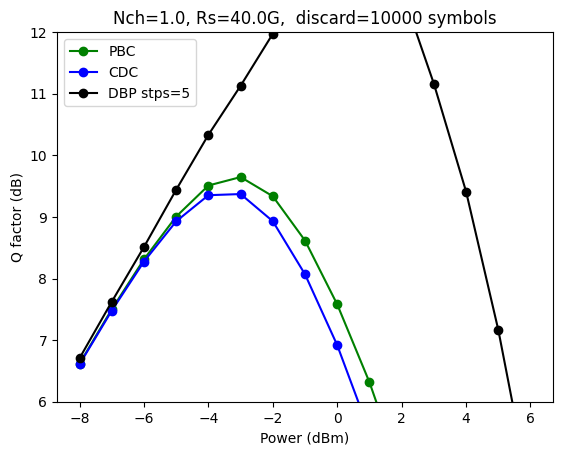

In [21]:
discard = 10000
i,j = 1,0

Q2,Rs,Nch,P = get_Qsq('../outputs/Qfactor/Q2000/MTLoss/pbc.pkl', discard=discard)
pbc = Q2['pbc'][i, j]

Q1,Rs,Nch,P = get_Qsq('../outputs/Qfactor/Q2000/baselines.pkl', discard=discard)
cdc = Q1['CDC'][i, j,:]

Q, Rs, Nch, P = getQsq_fromdir('../outputs/Qfactor/Q2000/hpbc_MTLoss/', discard=discard)

plt.figure(dpi=100)
plt.plot(P, pbc,'-o', label='PBC')
plt.plot(P, cdc,'-o', label='CDC')
plt.plot(P, Q1['DBP stps=5'][i,j], '-o', label='DBP stps=5')
for key in Q.keys():
    if key in ['hpbc_2', 'hpbc_3', 'hpbc_4']:
        plt.plot(P, Q[key][i, j ,:], '-o', label=key)


plt.xlabel('Power (dBm)')
plt.ylabel('Q factor (dB)')
plt.ylim(6, 12)
plt.legend()
plt.title(f'Nch={Nch[j]}, Rs={Rs[i]}G,  discard={discard} symbols')